In [315]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554417 entries, 0 to 554416
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        554417 non-null  object        
 1   product_id        554417 non-null  object        
 2   quantity          554417 non-null  int64         
 3   unit_price        554417 non-null  float64       
 4   total_sale        554417 non-null  float64       
 5   customer_id       554417 non-null  object        
 6   rating            554417 non-null  float64       
 7   review_count      554417 non-null  int64         
 8   country           554417 non-null  object        
 9   product_name      554417 non-null  object        
 10  product_type      554417 non-null  object        
 11  stock_code        554417 non-null  object        
 12  invoice_datetime  554417 non-null  datetime64[ns]
 13  day_of_week       554417 non-null  int64         
 14  mont

In [4]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


<h3> Function for computing returning customer rate </h3>

In [283]:
def returning_customer_rate(measure_date):
    """
    Compute returning customer rate

    Arguments:
    date of measurement 

    Returns:
    (# customers making more than one order, total # customers, ratio between the two)
    """
    
    # slice dataframe within time_period
    df_slice = merged_table[(merged_table['invoice_date']<= measure_date)]
    
    # for each customer_id, count number of unique orders (invoice_no)
    df_slice_agg = df_slice.groupby('customer_id')['invoice_no'].nunique().reset_index().rename(columns = {'invoice_no': 'num_orders'})
    
    # Count number of customers with more than one order, and at least one order, respectively
    more_than_one = df_slice_agg[df_slice_agg['num_orders'] > 2]['customer_id'].nunique()
    at_least_one = df_slice_agg[df_slice_agg['num_orders'] >= 1]['customer_id'].nunique()

    return more_than_one, at_least_one, round(100*more_than_one/at_least_one,2)
    

In [284]:
# compute returning_customer_rate for each month: 
measure_dates= ['2019-01-01', '2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01','2019-08-01',
                '2019-09-01','2019-10-01','2019-11-01','2019-12-01']

return_customers = []
total_num_customers = []
return_rates = []
for date in measure_dates:
    return_customers.append((returning_customer_rate(date))[0])
    total_num_customers.append((returning_customer_rate(date))[1])
    return_rates.append((returning_customer_rate(date))[2])

In [285]:
print(return_customers)

[94, 234, 368, 515, 629, 833, 989, 1156, 1302, 1485, 1686, 1963]


In [286]:
print(total_num_customers)

[886, 1333, 1704, 2151, 2439, 2726, 2966, 3158, 3325, 3617, 3986, 4302]


In [287]:
print(return_rates)

[10.61, 17.55, 21.6, 23.94, 25.79, 30.56, 33.34, 36.61, 39.16, 41.06, 42.3, 45.63]


Tiny percentage in the early months means a large number of customers joined / made their first purchase <br> 
when they first joined in Dec 2018, and very few of them purchased again. 

In [250]:
# Stats on number of purchases per customer
merged_table.groupby('customer_id')['invoice_datetime'].nunique().reset_index().rename(columns = {'invoice_datetime':'num_orders'}).describe()

,num_orders
count,4340.000000
mean,4.166590
std,16.458378
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,997.000000


<h3> Function for computing number of new customers </h3>

In [292]:
def num_new_customers(time_period):
    """
    Compute number of new customers within time_period

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    num_new_customers, num_all_customers
    """
    start_date, end_date = time_period
    
    # All customers by end of time period
    num_all_customers = merged_table[merged_table['invoice_date']<= end_date]['customer_id'].nunique()

    # existing customers before start_date:
    existing = merged_table[merged_table['invoice_date'] < start_date]['customer_id'].unique().tolist()

    # customers within time period
    df_slice = merged_table[(merged_table['invoice_date']>=start_date) & (merged_table['invoice_date']<=end_date)]['customer_id'].unique().tolist()



    new_customers = set(df_slice) - set(existing)
    num_new_customers = len(new_customers)

    return num_new_customers, num_all_customers

In [296]:
# compute number of new customers for each month: 
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-31'), ('2019-03-01', '2019-03-31'),
                ('2019-04-01', '2019-04-31'), ('2019-05-01', '2019-05-31'), ('2019-06-01', '2019-06-31'), ('2019-07-01', '2019-07-31'),
                ('2019-08-01', '2019-08-31'), ('2019-09-01', '2019-09-31'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-31'),
                ('2019-12-01', '2019-12-31') ]

months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

all_customers = []
new_customer_counts = []

for time_period in time_periods:
    new_customer_counts.append(num_new_customers(time_period)[0])
    all_customers.append(num_new_customers(time_period)[1])



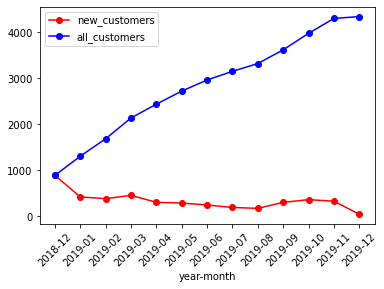

In [305]:
fig, ax = plt.subplots(1,1)
ax.plot(months, new_customer_counts, color = 'r', label = 'new_customers', marker = 'o')
ax.plot(months, all_customers, color = 'b', label = 'all_customers', marker = 'o')
ax.set_xlabel('year-month')
ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.legend()

plt.show()

<h3> Function for computing number of idle customers </h3>

In [57]:
def idle_customers(time_period):
    """
    Compute number of idle customers within time_period

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    num_idle_customers, num_all_customers, num_idle_customers/num_all_customers
    
    """
    start_date, end_date = time_period

    # Customers who made a purchase within time_period
    purchasers = merged_table[(merged_table['invoice_date'] >= start_date) & (merged_table['invoice_date'] <= end_date)]['customer_id'].unique().tolist()

    # All existing customers within time_period
    existing = merged_table[(merged_table['invoice_date'] < end_date)]['customer_id'].unique().tolist()

    num_idle_customers = len(set(existing)) - len (set(purchasers))
    num_all_customers = len(set(existing))

    return num_idle_customers, num_all_customers, round (100 * num_idle_customers / num_all_customers, 2)


In [288]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-31'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-31'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-31'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-31'), ('2019-10-01', '2019-10-31'),('2019-11-01', '2019-11-31'),
                ('2019-12-01', '2019-12-31')
                ]

idle_customer_rates = []
for time_period in time_periods:
    idle_customer_rates.append(idle_customers(time_period)[2])



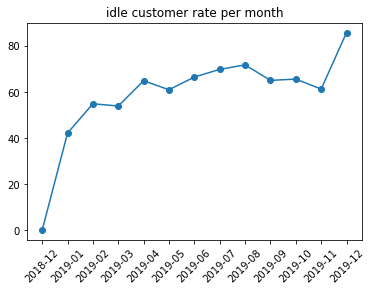

In [290]:
months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1)
ax.plot(months, idle_customer_rates, marker = 'o')
ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.set_title('idle customer rate per month')
plt.show()

- Graph shows percentage of existing customers that DID NOT make a purchase in each month. <br>
- Bear in mind that the data only goes up to 9 Dec 2019. So the unusually high idle customer rate in 2019–12 is misrepresentative. <br>
- Idle customer rate seems to plateau at around 60–70 percent from 2019–04 onwards. <br>
- Also, the idle rate is 0 for 2018–12, because the data begins in Dec 2018.


<h3> Function for computing purchase rate (# orders per day within time period) </h3>

In [317]:
def purchase_rate(time_period):

    """
    Compute number of idle customers within time_period

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    purchase_rate (num_orders / num_days)
    """

    start_date, end_date = time_period

    temp_df = merged_table[(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date)]
    num_invoices = len(temp_df['invoice_no'].unique())
    num_days = (datetime.strptime(end_date,'%Y-%m-%d') - datetime.strptime(start_date,'%Y-%m-%d')).days
    num_days
    purchase_rate = num_invoices/num_days
    return round(purchase_rate,2)
    

In [321]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_rates = []
for time_period in time_periods:
    purchase_rates.append(purchase_rate(time_period))

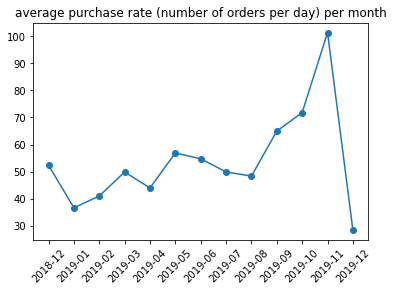

In [324]:
months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1)
ax.plot(months,  purchase_rates, marker = 'o')
ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.set_title('average purchase rate (number of orders per day) per month')
plt.show()

Again, data for 2019–12 is incomplete. So the purchase rate appears lower for that month.

<h3> Average revenue per day (revenue per day within time period) </h3>

In [311]:
def average_revenue(time_period):

    """
    Compute average revenue per day within time_period

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    average_revenue
    """

    start_date, end_date = time_period

    total_revenue = merged_table [(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date)]['total_sale'].sum()
    num_days = (datetime.strptime(end_date,'%Y-%m-%d') - datetime.strptime(start_date,'%Y-%m-%d')).days
    average_revenue = total_revenue/num_days
    return average_revenue
    

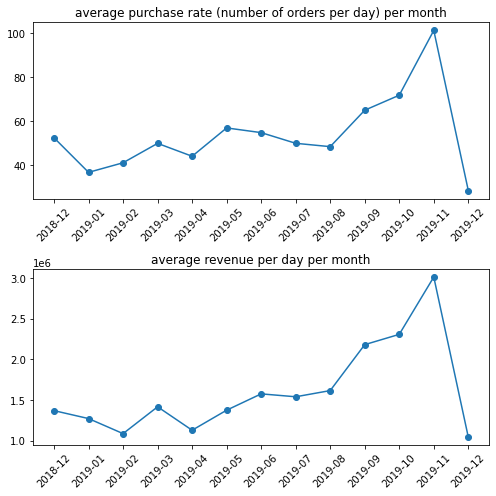

In [327]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_rates = []
for time_period in time_periods:
    purchase_rates.append(purchase_rate(time_period))

average_revenues = []
for time_period in time_periods:
    average_revenues.append(average_revenue(time_period))

months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(2,1, figsize = (7,7))

ax[0].plot(months, purchase_rates, marker = 'o')
ax[0].set_title('average purchase rate (number of orders per day) per month')
ax[0].set_xticks(ticks = months)
ax[0].set_xticklabels(labels = months, rotation = 45)

ax[1].plot(months, average_revenues, marker = 'o')
ax[1].set_title ('average revenue per day per month')
ax[1].set_xticks(ticks = months)
ax[1].set_xticklabels(labels = months, rotation = 45)
plt.tight_layout()
plt.show()


<h3> Number of orders per customer </h3> 

In [48]:
orders_per_customer = merged_table.groupby(['customer_id', 'country'])['invoice_no'].nunique().reset_index().sort_values(by = 'invoice_no', ascending = False)
orders_per_customer.rename(columns = {'invoice_no': 'num_orders'}, inplace = True)
orders_per_customer = orders_per_customer[orders_per_customer['customer_id'] != 'Null'] # Drop row where customer_id == Null
orders_per_customer.head()

,customer_id,country,num_orders
334,12748,Germany,211
1888,14911,Ireland,201
4019,17841,Germany,125
570,13089,Germany,98
1670,14606,Germany,92


In [51]:
# Excluding Germany

orders_per_customer[orders_per_customer['country']!= 'Germany'].head(20)

,customer_id,country,num_orders
1888,14911,Ireland,201
1698,14646,Netherlands,73
1342,14156,Ireland,55
185,12569,United Kingdom,32
281,12682,France,31
108,12471,United Kingdom,28
312,12720,United Kingdom,26
280,12681,France,22
231,12621,United Kingdom,21
57,12415,Australia,20


In [348]:
merged_table[merged_table['customer_id']== '14911']['total_sale'].sum()/1000000
#merged_table[merged_table['customer_id']== '14911']['quantity'].sum()
#merged_table[merged_table['customer_id']== '14911']['unit_price'].unique()

9.34022433

In [349]:
merged_table[merged_table['customer_id']== '14646']['total_sale'].sum()/1000000
#merged_table[merged_table['customer_id']== '14646']['quantity'].sum()



21.664738299999996

In [50]:
orders_per_customer.describe()

,num_orders
count,4347.000000
mean,4.271912
std,7.719016
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,211.000000


Median number of orders: 2 <br>
Mean: 4.27 <br>
Upper quartile: 5 orders or above <br>

<h3> Highest revenue customers for 2019 </h3>

In [405]:
top_revenue = merged_table[merged_table['invoice_datetime'].dt.year == 2019].groupby('customer_id')['total_sale'].sum().reset_index().rename(columns = {'total_sale':'total_revenue'})
#top_revenue['total_revenue (in m)'] = top_revenue['total_revenue (in m)'] / 1000000
top_revenue = top_revenue.sort_values(by = 'total_revenue', ascending = False)
top_revenue = top_revenue[top_revenue['customer_id']!= 'Null']

# Check how many customers spent more than 100,000:
customers_100k = top_revenue[top_revenue['total_revenue']>100000]        # 1062 rows

# Check how many customers spent more than 10,000:
customers_10k = top_revenue[top_revenue['total_revenue']>10000]       # 3473 rows

len(customers_100k), len (customers_10k)

(1062, 3473)

Wow. Okay, so around 75% of all customers spent over 10k in 2019 alone. This means a huge number of customers are bulk buyers.

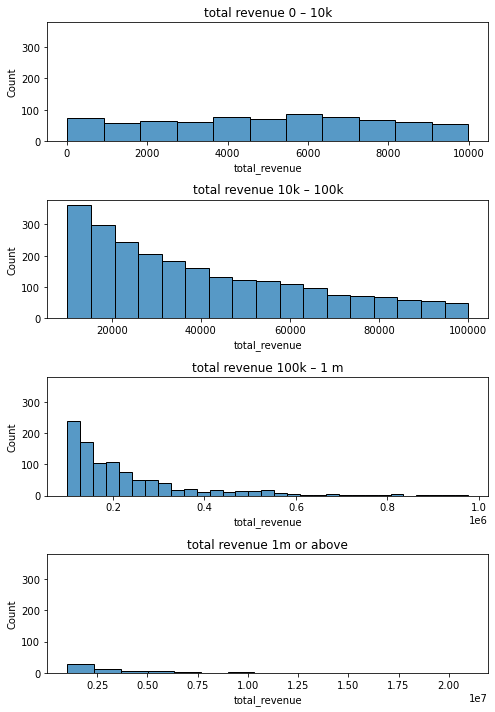

In [416]:
# Provisional division lines: 
# 0 – 10k
# 10k – 100k
# 100k or above

fig, ax = plt.subplots(4,1, figsize = (7,10), sharey = True)
# 0 – 10k
sns.histplot(ax = ax[0], x = top_revenue [top_revenue['total_revenue']< 10000]['total_revenue'])
ax[0].set_title('total revenue 0 – 10k')
# 10k – 100k
sns.histplot(ax = ax[1], x = top_revenue [(top_revenue['total_revenue']>= 10000) & (top_revenue['total_revenue']< 100000)]['total_revenue'])
ax[1].set_title('total revenue 10k – 100k')

# 100k–1m
sns.histplot(ax = ax[2], x = top_revenue [(top_revenue['total_revenue']>= 100000) &(top_revenue['total_revenue']< 1000000)]['total_revenue'])
ax[2].set_title('total revenue 100k – 1 m')

# 1m or above
sns.histplot(ax = ax[3], x = top_revenue [(top_revenue['total_revenue']>= 1000000)]['total_revenue'])
ax[3].set_title('total revenue 1m or above')

plt.tight_layout()
plt.show()

In [426]:
# 0 – 10k -- private customers

customers_0_10k = len(top_revenue[(top_revenue['total_revenue']>0)&(top_revenue['total_revenue']<10000)])

# 10k – 100k -- small business customers
customers_10k_100k = len(top_revenue[(top_revenue['total_revenue']>=10000)&(top_revenue['total_revenue']<100000)])

# 100k–1m -- medium business customers
customers_100k_1m = len(top_revenue[(top_revenue['total_revenue']>=100000)&(top_revenue['total_revenue']<1000000)])

# 1m or above -- big business customers
customers_1m_or_above = len(top_revenue[(top_revenue['total_revenue']>=1000000)])

customers_0_10k, customers_10k_100k, customers_100k_1m, customers_1m_or_above, customers_0_10k + customers_10k_100k+ customers_100k_1m + customers_1m_or_above

(747, 2411, 1007, 55, 4220)

In [427]:
merged_table['customer_id'].nunique()

4340

Wait ... where did my 120 customers go???

Ok this is interesting: <br>

- A rather small number of customers (747 out of 4220) are private users
- The majority of customers are business customers, which we have (quit arbitrarily) divided into three classes: small, medium, big
- This means we want to cater to the non-private customers as a priority
- Find out if there is a difference in the kinds of products private vs business customers tend to buy

<h3> Number of units ordered per customer </h3>

<h5> For each customer, in each month, see percentage of existing customers who have not ordered in the last X time period </h5>

In [335]:
one_month_periods = [('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-31'), ('2019-03-01', '2019-03-31'),
                    ('2019-04-01', '2019-04-31'), ('2019-05-01', '2019-05-31'), ('2019-06-01', '2019-06-31'), ('2019-07-01', '2019-07-31'),
                    ('2019-08-01', '2019-08-31'), ('2019-09-01', '2019-09-31'), ('2019-10-01', '2019-10-31'),('2019-11-01', '2019-11-31'),
                    ('2019-12-01', '2019-12-31')]
quarterly_periods = [('2019-01-01', '2019-03-31'), ('2019-04-01', '2019-06-30'),('2019-07-01', '2019-09-30'), ('2019-10-01', '2019-12-31') ]
six_month_periods = [('2019-01-01', '2019-06-30'), ('2019-07-01', '2019-12-31')]

monthly_idle = []
quarterly_idle = []
six_monthly_idle = []

for per in one_month_periods: 
    monthly_idle.append(idle_customers(per))

for per in quarterly_periods: 
    quarterly_idle.append(idle_customers(per))

for per in six_month_periods:
    six_monthly_idle.append(idle_customers(per))

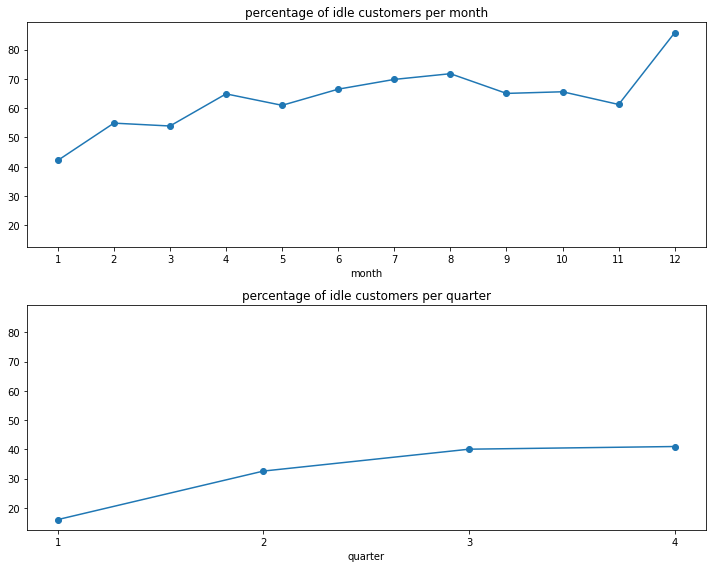

In [331]:
monthly = [elem [2] for elem in monthly_idle]
quarterly = [elem [2] for elem in quarterly_idle]
bi_annually = [elem [2] for elem in six_monthly_idle]



fig, ax = plt.subplots(2,1, figsize = (10,8), sharey = True)

ax[0].plot(list(range(1, len(monthly_idle)+1)), monthly, marker = 'o')
ax[0].set_title('percentage of idle customers per month')
ax[0].set_xticks(list(range(1, len(monthly_idle)+1)))
ax[0].set_xlabel('month')

ax[1].plot(list(range(1, len(quarterly_idle)+1)), quarterly, marker = 'o')
ax[1].set_title('percentage of idle customers per quarter')
ax[1].set_xticks(list(range(1, len(quarterly_idle)+1)))
ax[1].set_xlabel('quarter')

# ax[2].plot(list(range(1, len(six_monthly_idle)+1)), bi_annually, marker = 'o')
# ax[2].set_title('percentage of idle customers per six months')
# ax[2].set_xticks(list(range(1, len(six_monthly_idle)+1)))
# ax[2].set_xlabel('half of year')


plt.tight_layout()
plt.show()


<h3> Average number of days since last purchase </h3>

In [195]:
def most_recent_order (measure_date):
    """
    Create dataframe showing number of days since last order for each customer

    Arguments:
    measure_date -- single date, in format 'yyyy-mm-dd'

    Returns:
    (dataframe, average number of days since last order) 
    Dataframe ahs columns "customer_id", "last_order", "measure_date", "days_since_last_order"
    
    """
    
    dummy = merged_table.copy(deep = True)
    dummy['before_measure_date'] = dummy['invoice_datetime'] < measure_date
    dummy = dummy[dummy['before_measure_date'] == True]
    dummy = dummy.groupby('customer_id')['invoice_date'].max().reset_index().rename(columns = {'invoice_date': 'last_order'})
    dummy['measure_date'] = measure_date
    dummy['last_order'] = pd.to_datetime(dummy['last_order'])
    dummy['measure_date'] = pd.to_datetime(dummy['measure_date'])
    dummy['days_since_last_order'] =  (dummy['measure_date'] - dummy['last_order']).dt.days
    return (dummy, round (dummy['days_since_last_order'].mean(),2))


In [196]:
x = most_recent_order('2019-06-30')
x[1]

72.02

In [333]:
measure_dates = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01',
                '2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01', ]
days_since_last_order = []
for date in measure_dates:
    days_since_last_order.append(most_recent_order(date)[1])

#days_since_last_order  



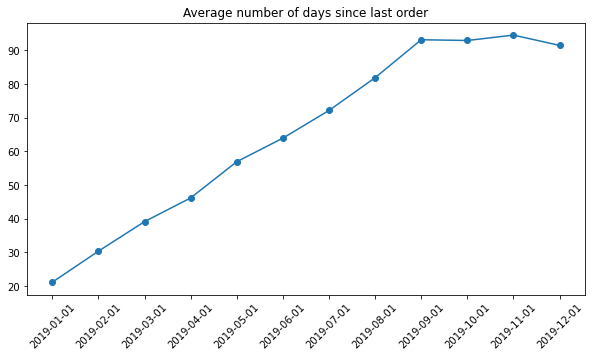

In [334]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(measure_dates, days_since_last_order, marker = 'o')
ax.set_title('Average number of days since last order')
ax.set_xticks(measure_dates)
ax.set_xticklabels(measure_dates, rotation = 45)
plt.show()

In [242]:
start_date = datetime.date(2019, 1, 1)
number_of_days = 365
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(0, number_of_days, 15)] # Date every 15 days


days_since_last_order = []
for date in date_list:
    days_since_last_order.append(most_recent_order(date)[1])


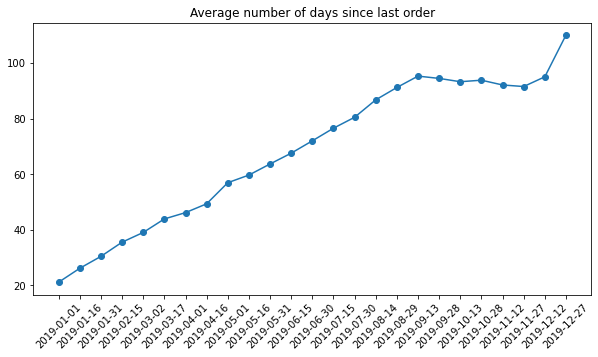

In [243]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(date_list, days_since_last_order, marker = 'o')
ax.set_title('Average number of days since last order')
ax.set_xticks(date_list)
ax.set_xticklabels(date_list, rotation = 45)
plt.show()

<h3> Correlation with rating of top selling products </h3>

<h3> Identify worst-selling products. Phase out of stock? </h3>

<h3> Number of orders per country </h3>

In [21]:
merged_table.groupby('country')['invoice_no'].nunique().reset_index().sort_values(by = 'invoice_no', ascending = False)

,country,invoice_no
12,Germany,18709
34,United Kingdom,478
11,France,389
16,Ireland,288
3,Belgium,99
23,Netherlands,94
30,Spain,89
0,Australia,56
26,Portugal,56
32,Switzerland,50
